<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [ ]:
# For colab
#!pip install numpy pandas scipy sklearn tqdm matplotlib seaborn --upgrade

In [ ]:
# from __future__ import division, print_function
# # отключим всякие предупреждения Anaconda
# import warnings
# warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [ ]:
# Поменяйте на свой путь к данным
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_TO_DATA = '/content/drive/My Drive/ML\DS/Yandex_MIPT_coursera/Course6/Final1/capstone_user_identification/'
else:
    PATH_TO_DATA = 'capstone_user_identification/'

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [ ]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [ ]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

In [ ]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [ ]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [ ]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [ ]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [ ]:
def get_sparse_matrix(X):
    '''
    Converts session matrix X to sparse of specified shape
    '''
    rows, cols, vals = np.asarray(list(itertools.chain.from_iterable([zip([i]*len(row), \
               *np.unique(row, return_counts=True)) for i, row in enumerate(X)]))).T

    return csr_matrix((vals, (rows, cols)), shape=(len(X), np.max(X)+1))[:, 1:]

In [ ]:
%%time
try:
    with open(os.path.join(PATH_TO_DATA, 'train_test_sparse.pkl'), 'rb') as train_test_sparse_pkl:
        train_test_sparse = pickle.load(train_test_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'rb') as X_train_sparse_pkl:
        X_train_sparse = pickle.load(X_train_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'rb') as X_test_sparse_pkl:
        X_test_sparse = pickle.load(X_test_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
        y = pickle.load(train_target_pkl)
except FileNotFoundError:
    print('Files not found. Creating.')

    train_test_sparse = get_sparse_matrix(train_test_df_sites.values)
    X_train_sparse = train_test_sparse[:len(train_df)]
    X_test_sparse = train_test_sparse[-len(test_df):]
    y = train_df.target.values

    with open(os.path.join(PATH_TO_DATA, 'train_test_sparse.pkl'), 'wb') as train_test_sparse_pkl:
        pickle.dump(train_test_sparse, train_test_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
        pickle.dump(X_train_sparse, X_train_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
        pickle.dump(X_test_sparse, X_test_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
        pickle.dump(y, train_target_pkl)

Files not found. Creating.
CPU times: user 11.3 s, sys: 465 ms, total: 11.7 s
Wall time: 11.8 s


**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [ ]:
print('Размерности матриц')
print('{0} {1} {2} {3}'.format(*X_train_sparse.shape, *X_test_sparse.shape))

Размерности матриц
253561 48371 82797 48371


**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [ ]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [ ]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [ ]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [ ]:
sgd_logit_roc_auc = roc_auc_score(y_valid, logit_valid_pred_proba)
print(f'SGD Logit ROC AUC = {sgd_logit_roc_auc:.3f}')

SGD Logit ROC AUC = 0.934


**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [ ]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

CPU times: user 579 ms, sys: 114 ms, total: 693 ms
Wall time: 563 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(logit_test_pred_proba, 'sgdbase.csv')

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пробуем улучшить результат
С нашим бейзлайном получили результат 0.91646 на kaggle. Чтобы полностью выполнить задание, необходимо получить как минимум 0.92784. Попробуем добавлять признаки, которые мы делали в предыдущих заданиях.

In [ ]:
def new_features1(data):
    
    feature_names = ['time_diff%i' % i for i in range(1, 10)] + \
                    ['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']
    diffs = []
    timespans = []
    unique_sites = []
    start_hours = []
    days_of_week = []
    times_columns = ['time%i' % i for i in range(1, 11)]
    sites_columns = ['site%i' % i for i in range(1, 11)]
    
    # Заполняем нулями все пропущенные сайты, а все пропущенные времена заполняем последним известным
    data.loc[:, times_columns] = data.loc[:, times_columns].ffill(axis=1).astype('datetime64')
    data.loc[:, sites_columns] = data.loc[:, sites_columns].fillna(0).astype('int')
    
    for ind in tqdm(range(len(data))):
        row = data.iloc[ind]
        # Получаем количество уникальных сайтов в сессии
        num_unique = len({x for x in row.loc[sites_columns] if x})
        # Получаем времена захода на сайты
        timestamps = row.loc[times_columns]
        # Получаем разницу времени между заходом на следующий сайт (информация по последнему сайту неизвестна)
        diff = list(map(lambda x: x.total_seconds(), np.diff(timestamps)))
        
        # Получаем время сессии. Будем её считать как разницу между заходом на первый и на последний сайт
        # Мы знаем, что сессия максимально длится полчаса, поэтому если у сайта 10 id 0, то прошли 30 минут
        # Если сайт не 0, то просто считаем, что пользователь там провёл 0 секунд, хотя он вполне мог бы там пробыть до конца 30 минут
        # Но попробуем такое допущение, иначе смысла в признаке не будет
        timespan = (row['time10'] - row['time1']).total_seconds() if row['site10'] else 30*60
        hour = row['time1'].hour
        dow = row['time1'].dayofweek
        
        # Создаём строки и столбцы будущего DataFrame
        diffs.append(diff)
        timespans.append(timespan)
        unique_sites.append(num_unique)
        start_hours.append(hour)
        days_of_week.append(dow)

    # Создаём DataFrame из разниц времени между переходами на следующий сайт
    df = pd.DataFrame(diffs)

    # Добавляем остальные созданные столбцы и даём им имена
    other_features_df = pd.DataFrame(np.stack([timespans, unique_sites,
                                                start_hours, days_of_week], axis=1)) 

    df = pd.concat([df, other_features_df], axis=1).astype('int')
    df.columns = feature_names

    return df

In [ ]:
# Применим функцию для совместного датасета (train + test)
new_feat_df1 = new_features1(train_test_df)

In [ ]:
# Загрузка новых признаков из файла либо их создание+запись
try:
    with open(os.path.join(PATH_TO_DATA, 'train_test_new_feat1.pkl'), 'rb') as new_feat1_file:
        new_feat_df1 = pickle.load(new_feat1_file)
except FileNotFoundError:
    print('File not found. Creating.')
    new_feat_df1 = new_features1(train_test_df)
    with open(os.path.join(PATH_TO_DATA, 'train_test_new_feat1.pkl'), 'wb') as new_feat1_file:
        pickle.dump(new_feat_df1, new_feat1_file)

In [ ]:
new_feat_df1.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week
0,0,0,0,0,0,0,0,0,0,1800,1,10,3
1,0,1,0,0,0,1,0,23,1,26,7,11,5
2,1,1,0,0,0,1,1,1,2,7,4,16,0
3,30,30,30,30,30,30,30,30,30,270,1,10,4
4,137,0,1,0,36,0,0,67,5,246,4,10,4


### Посмотрим немного на картинки новых признаков.

**1. Средняя длительность нахождения на сайте в сессии**

In [ ]:
new_feat1_train = new_feat_df1[:len(train_df)]
new_feat1_test = new_feat_df1[-len(test_df):]
sns.set(font_scale=1.5, rc={'figure.figsize': (12,7)})

In [ ]:
time_diffs = ['time_diff%i' % i for i in range(1, 10)]
mean_time_diffs_train = new_feat1_train[time_diffs].mean(axis=1)
mean_time_diffs_train.describe()

count    253561.000000
mean         15.388263
std          32.864638
min           0.000000
25%           0.777778
50%           3.000000
75%          12.555556
max         200.000000
dtype: float64

In [ ]:
mean_time_diffs_test = new_feat1_test[time_diffs].mean(axis=1)
mean_time_diffs_test.describe()

count    82797.000000
mean        14.894466
std         31.684195
min          0.000000
25%          0.777778
50%          3.444444
75%         12.222222
max        200.000000
dtype: float64

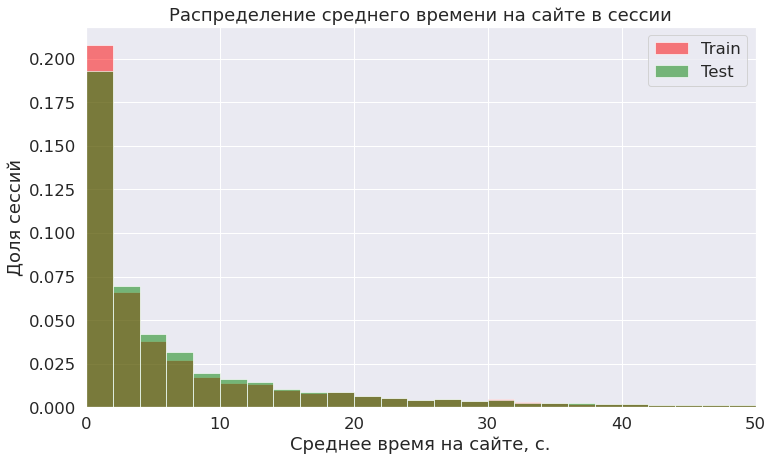

In [ ]:
sns.histplot(mean_time_diffs_train, bins=100, stat='density', color='red', label='Train', alpha=0.5)
sns.histplot(mean_time_diffs_test, bins=100, stat='density', color='green', label='Test', alpha=0.5)
plt.xlim(0, 50)
plt.xlabel('Среднее время на сайте, с.')
plt.ylabel('Доля сессий')
plt.title('Распределение среднего времени на сайте в сессии')
plt.legend();

Распределения тренировочного и тестового множества похожи. Большая часть всех значений лежит в районе 20 секунд. Дальше у распределения очень тяжёлый хвост.

Посмотрим распределения отдельно для Элис и остальных пользователей.

In [ ]:
mean_time_diffs_train_wt = pd.concat([mean_time_diffs_train, pd.Series(y)], axis=1)

In [ ]:
mtdt_not_alice = mean_time_diffs_train_wt[mean_time_diffs_train_wt[1] == 0][0]
mtdt_alice = mean_time_diffs_train_wt[mean_time_diffs_train_wt[1] == 1][0]

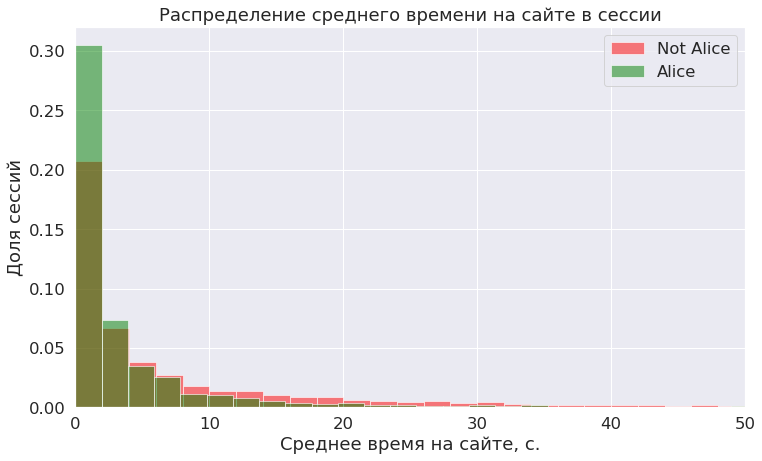

In [ ]:
sns.histplot(mtdt_not_alice, color='red', stat='density', bins=100, label='Not Alice', alpha=0.5)
sns.histplot(mtdt_alice, color='green', stat='density', bins=100, label='Alice', alpha=0.5)
plt.xlim(0, 50)
plt.xlabel('Среднее время на сайте, с.')
plt.ylabel('Доля сессий')
plt.title('Распределение среднего времени на сайте в сессии')
plt.legend();

Распределения похожи. Разве что Элис находится на сайтах в среднем чуть меньше. Возможно, это позволит помочь распознать Элис.

**2. Длительность сессии**

In [ ]:
sess_time_train = new_feat1_train['session_timespan']
sess_time_test = new_feat1_test['session_timespan']
print(f'{sess_time_train.describe()}\n\n{sess_time_test.describe()}')

count    253561.000000
mean        268.747777
std         535.319084
min           0.000000
25%           8.000000
50%          34.000000
75%         163.000000
max        1800.000000
Name: session_timespan, dtype: float64

count    82797.000000
mean       278.269901
std        547.561456
min          0.000000
25%         10.000000
50%         40.000000
75%        163.000000
max       1800.000000
Name: session_timespan, dtype: float64


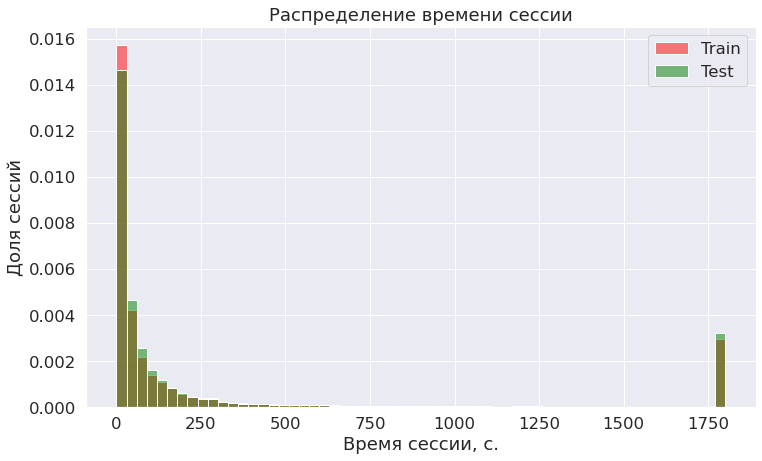

In [ ]:
sns.histplot(sess_time_train, stat='density', bins=60, color='red', label='Train', alpha=0.5)
sns.histplot(sess_time_test, stat='density', bins=60, color='green', label='Test', alpha=0.5)
plt.xlabel('Время сессии, с.')
plt.ylabel('Доля сессий')
plt.title('Распределение времени сессии')
plt.legend();

In [ ]:
sess_time_train_wt = pd.concat([sess_time_train, pd.Series(y)], axis=1)
st_not_alice = sess_time_train_wt[sess_time_train_wt[0] == 0]['session_timespan']
st_alice = sess_time_train_wt[sess_time_train_wt[0] == 1]['session_timespan']

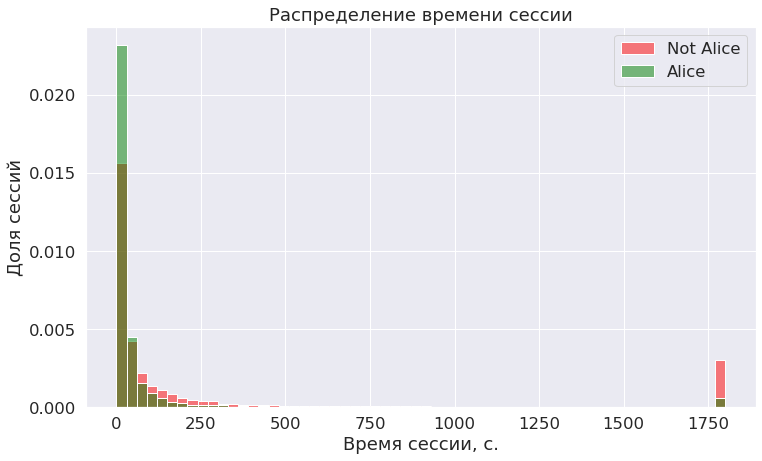

In [ ]:
sns.histplot(st_not_alice, color='red', stat='density', bins=60, label='Not Alice', alpha=0.5)
sns.histplot(st_alice, color='green', stat='density', bins=60, label='Alice', alpha=0.5)
plt.xlabel('Время сессии, с.')
plt.ylabel('Доля сессий')
plt.title('Распределение времени сессии')
plt.legend();

Опять у Элис в среднем время сессии меньше. Признак может помочь.

**3. Количество уникальных сайтов в сессии**

In [ ]:
unique_sites_train = new_feat1_train['unique_sites']
unique_sites_test = new_feat1_test['unique_sites']
print(f'{unique_sites_train.describe()}\n\n{unique_sites_test.describe()}')

count    253561.000000
mean          5.638391
std           2.496187
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: unique_sites, dtype: float64

count    82797.000000
mean         5.280650
std          2.626599
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: unique_sites, dtype: float64


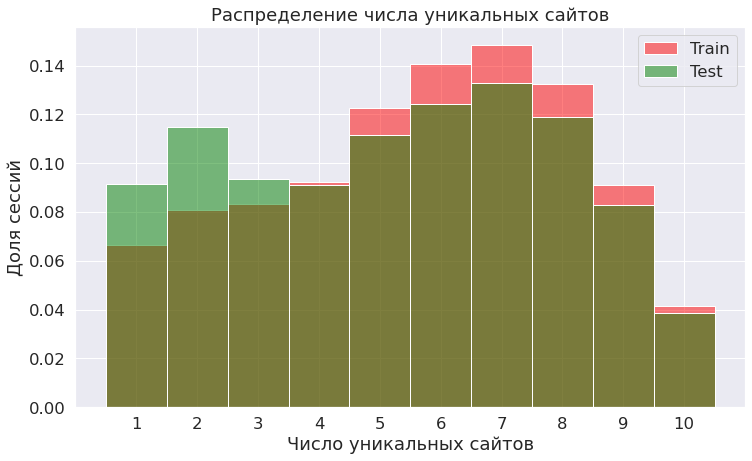

In [ ]:
sns.histplot(unique_sites_train, stat='density',  color='red', label='Train', alpha=0.5, discrete=True)
sns.histplot(unique_sites_test, stat='density',  color='green', label='Test', alpha=0.5, discrete=True)
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Доля сессий')
plt.title('Распределение числа уникальных сайтов')
plt.xticks(range(unique_sites_train.min(), unique_sites_train.max()+1))
plt.legend();

В тестовой выборке больше сессий, где число уникальных сайтов меньше, чем в тренировочной, но незначительно

In [ ]:
unique_sites_train_wt = pd.concat([unique_sites_train, pd.Series(y)], axis=1)
us_not_alice = unique_sites_train_wt[unique_sites_train_wt[0] == 0]['unique_sites']
us_alice = unique_sites_train_wt[unique_sites_train_wt[0] == 1]['unique_sites']

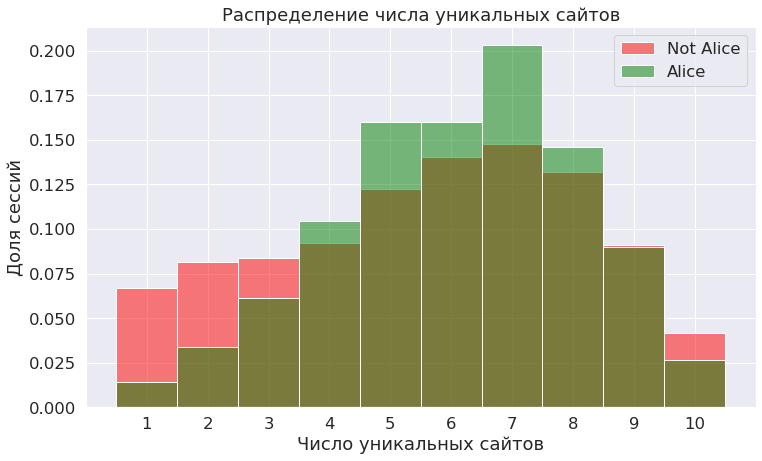

In [ ]:
sns.histplot(us_not_alice, color='red', stat='density', label='Not Alice', alpha=0.5, discrete=True)
sns.histplot(us_alice, color='green', stat='density', label='Alice', alpha=0.5, discrete=True)
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Доля сессий')
plt.title('Распределение числа уникальных сайтов')
plt.xticks(range(unique_sites_train.min(), unique_sites_train.max()+1))
plt.legend();

Элис чаще заходит на большое количество разных сайтов.

**4. Час начала сессии.**

In [ ]:
start_hour_train = new_feat1_train['start_hour']
start_hour_test = new_feat1_test['start_hour']
print(f'{start_hour_train.describe()}\n\n{start_hour_test.describe()}')

count    253561.000000
mean         12.288483
std           3.159420
min           7.000000
25%          10.000000
50%          12.000000
75%          15.000000
max          23.000000
Name: start_hour, dtype: float64

count    82797.000000
mean        12.504064
std          3.082344
min          7.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         23.000000
Name: start_hour, dtype: float64


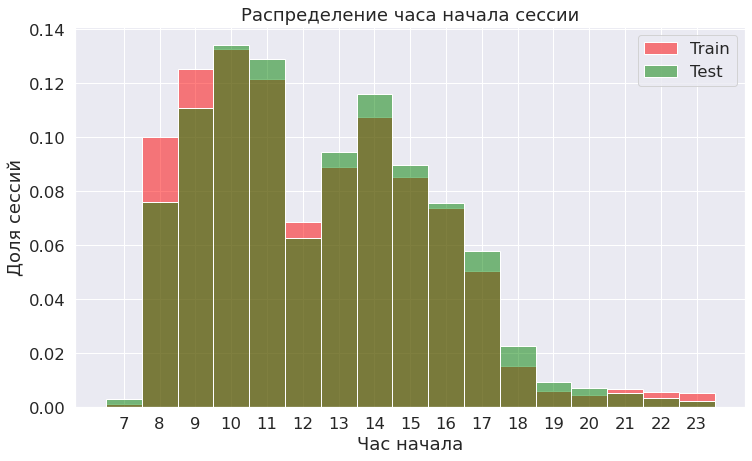

In [ ]:
sns.histplot(start_hour_train, stat='density',  color='red', label='Train', alpha=0.5, discrete=True)
sns.histplot(start_hour_test, stat='density',  color='green', label='Test', alpha=0.5, discrete=True)
plt.xlabel('Час начала')
plt.ylabel('Доля сессий')
plt.title('Распределение часа начала сессии')
plt.xticks(range(start_hour_train.min(), start_hour_train.max()+1))
plt.legend();

Тренировочное и тестовое распределение похожи

In [ ]:
start_hour_train_wt = pd.concat([start_hour_train, pd.Series(y)], axis=1)
sh_not_alice = start_hour_train_wt[start_hour_train_wt[0] == 0]['start_hour']
sh_alice = start_hour_train_wt[start_hour_train_wt[0] == 1]['start_hour']

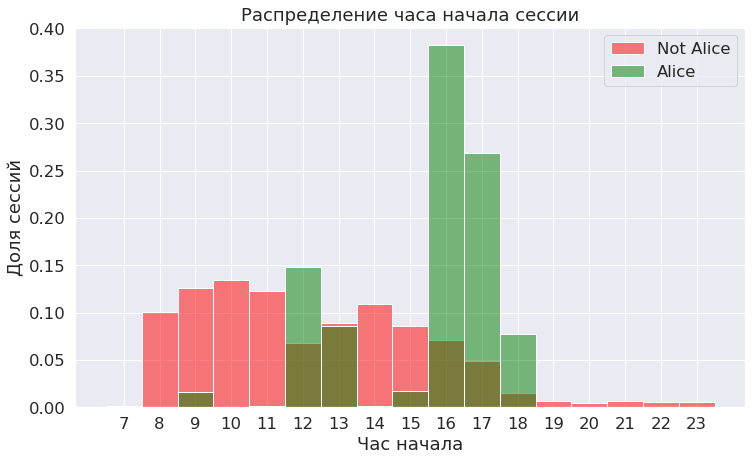

In [ ]:
sns.histplot(sh_not_alice, color='red', stat='density', label='Not Alice', alpha=0.5, discrete=True)
sns.histplot(sh_alice, color='green', stat='density', label='Alice', alpha=0.5, discrete=True)
plt.xlabel('Час начала')
plt.ylabel('Доля сессий')
plt.title('Распределение часа начала сессии')
plt.xticks(range(start_hour_train.min(), start_hour_train.max()+1))
plt.legend();

По этому признаку Элис сильно отличается от других юзеров. Её пик активности 16-17 часов. Однако этот признак лучше объединить в меньшее количество категорий. Но пока что оставим так.

**5. День недели**

In [ ]:
day_of_week_train = new_feat1_train['day_of_week']
day_of_week_test = new_feat1_test['day_of_week']
print(f'{day_of_week_train.describe()}\n\n{day_of_week_test.describe()}')

count    253561.000000
mean          2.289741
std           1.610467
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           6.000000
Name: day_of_week, dtype: float64

count    82797.000000
mean         2.963598
std          1.941522
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_of_week, dtype: float64


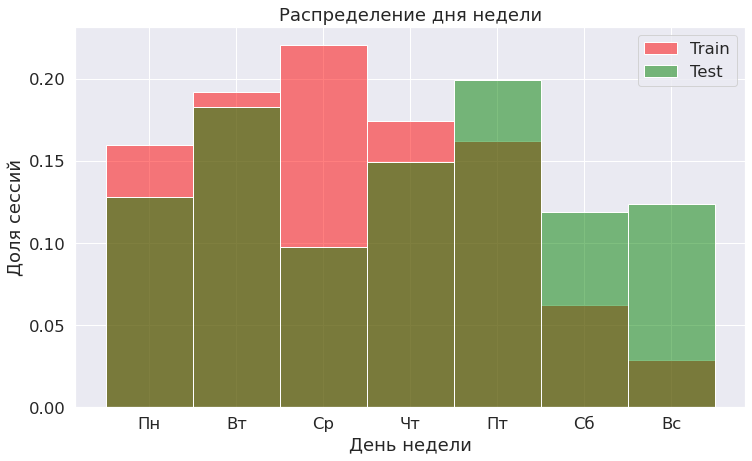

In [ ]:
sns.histplot(day_of_week_train, stat='density',  color='red', label='Train', alpha=0.5, discrete=True)
sns.histplot(day_of_week_test, stat='density',  color='green', label='Test', alpha=0.5, discrete=True)
plt.xlabel('День недели')
plt.ylabel('Доля сессий')
plt.title('Распределение дня недели')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.legend();

В тестовой выборке побольше данных в выходные, чем в тренировочной

In [ ]:
day_of_week_train_wt = pd.concat([day_of_week_train, pd.Series(y)], axis=1)
dow_not_alice = day_of_week_train_wt[day_of_week_train_wt[0] == 0]['day_of_week']
dow_alice = day_of_week_train_wt[day_of_week_train_wt[0] == 1]['day_of_week']

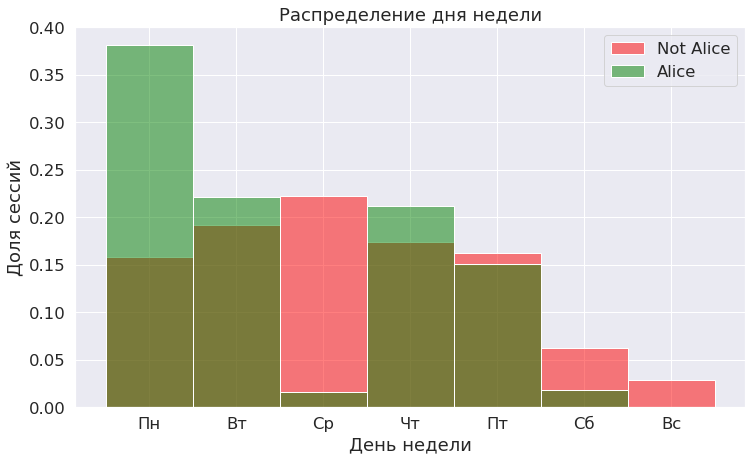

In [ ]:
sns.histplot(dow_not_alice, stat='density',  color='red', label='Not Alice', alpha=0.5, discrete=True)
sns.histplot(dow_alice, stat='density',  color='green', label='Alice', alpha=0.5, discrete=True)
plt.xlabel('День недели')
plt.ylabel('Доля сессий')
plt.title('Распределение дня недели')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.legend();

Элис больше, чем остальные юзеры активна в понедельник, совсем не активна по воскресеньям и слабо активна в среду и субботу.

### Попробуем добавить эти признаки и обучить классификатор

In [ ]:
from sklearn.model_selection import validation_curve, learning_curve

In [ ]:
# Добавим признаки в разреженную матрицу и поделим на train-test
def add_features_to_sparse(full_data, new_features, train_size):
    '''
    Add features to sparse matrices and split into train and test
    '''
    if new_features.ndim == 1:
        new_features = new_features.reshape(-1, 1)
    X_sparse_full = hstack([full_data, new_features], format='csr')
    X_train = X_sparse_full[:train_size]
    X_test = X_sparse_full[train_size:]
    return X_train, X_test

In [ ]:
def plot_learning_curve(estimator, X_train, y_train, cv=3, scoring='roc_auc'):
    '''
    Plot learning curves for estimator
    '''
    train_sizes = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
    sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, train_sizes=train_sizes,
                                                      cv=cv, scoring=scoring, random_state=17)
    sns.lineplot(x=sizes, y=train_scores.mean(axis=1), color='red', label='Train')
    sns.lineplot(x=sizes, y=test_scores.mean(axis=1), color='green', label='Test')
    plt.xlabel('Train size')
    plt.ylabel('ROC-AUC')
    plt.legend();

In [ ]:
def get_val_score(estimator, X, y, X_val, y_val):
    '''
    Fit estimator and get validation set score
    '''
    estimator.fit(X_train, y_train)
    val_pred = estimator.predict_proba(X_val)[:, 1]
    print(f'Validation ROC-AUC score = {roc_auc_score(y_val, val_pred):.5f}')

In [ ]:
sgd_new1 = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

Validation ROC-AUC score = 0.77143


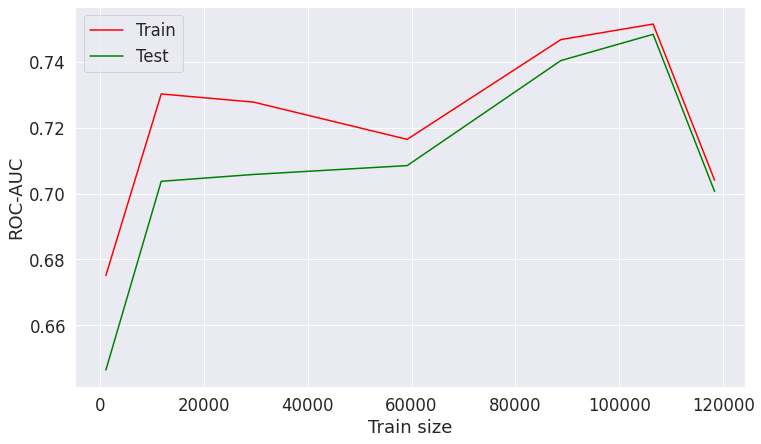

In [ ]:
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat_df1.values, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.3, random_state=17, shuffle=False)    
get_val_score(sgd_new1, X_train, y_train, X_val, y_val)
plot_learning_curve(sgd_new1, X_train, y_train)

Видим, что качество сильно просело. Похоже новые признаки наоборот делают только хуже, и модель не может найти хороших закономерностей в данных. Но наверняка не все из этих признаков плохие. Подозреваю, что виноваты признаки, связанные со временем нахождения на сайтах. Попробуем их убрать и добавить только признаки unique_sites, start_hour и day_of_week.

Validation ROC-AUC score = 0.89039


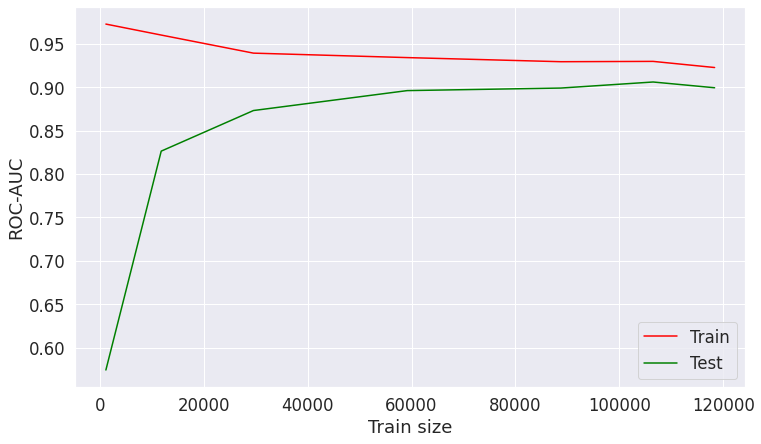

In [ ]:
add_feat = ['unique_sites', 'start_hour', 'day_of_week']
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat_df1[add_feat].values, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.3, random_state=17, shuffle=False)    
get_val_score(sgd_new1, X_train, y_train, X_val, y_val)
plot_learning_curve(sgd_new1, X_train, y_train)

Стало получше, но качество всё равно ниже, чем без этих признаков. Переделаем признаки start_hour и day_of_week в другие. Построим время суток и индикатор выходного дня и сделаем one-hot encoding.

In [ ]:
def build_time_of_day(data):
    '''
    Takes start hour and converts it to time_of_day
    0-6: night
    7-11: morning
    12-17: afternoon
    18-23: evening
    Returns new Series time_of_day
    '''
    tod = pd.Series([None] * len(data), name='time_of_day')
    tod[(data <= 23) & (data >= 18)] = 'evening'
    tod[(data <= 17) & (data >= 12)] = 'afternoon'
    tod[(data <= 11) & (data >= 7)] = 'morning'
    tod[(data <= 6) & (data >= 0)] = 'night'
    return pd.get_dummies(tod)

In [ ]:
def build_is_weekend(data):
    '''
    Takes day of week and checks if it's weekend day
    0-4: not weekend (0)
    5-6: weekend (1)
    Returns new Series is_weekend
    '''
    isw = pd.Series([0] * len(data), name='is_weekend', dtype=int)
    isw[(data <= 6) & (data >= 5)] = 1
    return isw

In [ ]:
time_of_day = pd.get_dummies(build_time_of_day(new_feat_df1.start_hour))
is_weekend = build_is_weekend(new_feat_df1.day_of_week)
new_feat2 = pd.concat([time_of_day, is_weekend], axis=1)
new_feat2

,afternoon,evening,morning,is_weekend
0,0,0,1,0
1,0,0,1,1
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
336353,0,1,0,0
336354,1,0,0,0
336355,0,0,1,0
336356,0,0,1,1


Validation ROC-AUC score = 0.96252


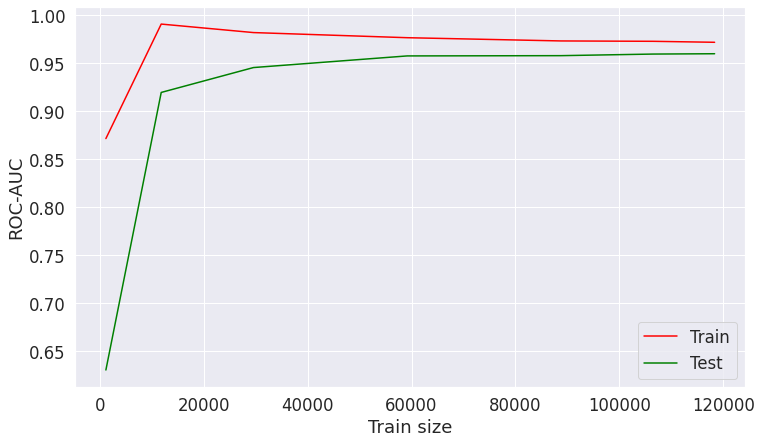

In [ ]:
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat2.values, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.3, random_state=17, shuffle=False)    
get_val_score(sgd_new1, X_train, y_train, X_val, y_val)
plot_learning_curve(sgd_new1, X_train, y_train)

Качество на валидации улучшилось. Попробуем отправить предсказания на kaggle.

In [ ]:
sgd_new1.fit(X_train_new, y)
test_pred = sgd_new1.predict_proba(X_test_new)[:, 1]

In [ ]:
write_to_submission_file(test_pred, 'sgd2feat1hot.csv')

Эта модель даёт на kaggle результат 0.94364. Так что бейзлайн мы побили, но можно попробовать улучшить ещё. Попробуем потюнить гиперпараметры.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'alpha': np.logspace(-1, -7, 7),
              'l1_ratio': np.linspace(0, 1, 5)
              }
cv_est = SGDClassifier(random_state=17, n_jobs=-1, penalty='elasticnet',)
gs_sgd_new = GridSearchCV(cv_est, param_grid=param_grid, scoring='roc_auc',
                        verbose=1, n_jobs=-1, return_train_score=True, cv=3)

In [ ]:
gs_sgd_new.fit(X_train, y_train)

Fitting 3 folds for each of 175 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 21.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='elasticnet', power_t=0.5,
                                     random_state=17, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07]),
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'loss':

In [ ]:
gs_sgd_new.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.0, 'loss': 'log'}

Validation ROC-AUC score = 0.97036


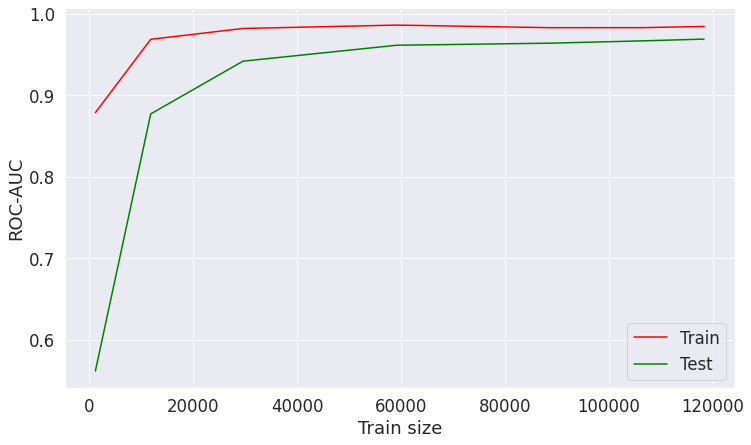

In [ ]:
get_val_score(gs_sgd_new.best_estimator_, X_train, y_train, X_val, y_val)
plot_learning_curve(gs_sgd_new.best_estimator_, X_train, y_train)

In [ ]:
best_gs_sgd = gs_sgd_new.best_estimator_

In [ ]:
best_gs_sgd.fit(X_train_new, y)
test_pred = best_gs_sgd.predict_proba(X_test_new)[:, 1]

In [ ]:
write_to_submission_file(test_pred, 'sgd2feat1hotgs.csv')

Качество стало ещё лучше. Но результат на kaggle меньше. Похоже с этими признаками мы больше ничего не добьёмся.

Кстати, скорее всего остальные созданные нами признаки ухудшали качество, из-за того, что они отличаются по масштабу от основных признаков. Попробуем добавить оставшиеся признаки, но отмасштабируем их в [0, 1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Создадим признак среднего времени нахождения на сайте
time_diffs = ['time_diff%i' % i for i in range(1, 10)]
new_feat_df1['mean_time_spent'] = new_feat_df1[time_diffs].mean(axis=1)
new_feat_df1.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,mean_time_spent
0,0,0,0,0,0,0,0,0,0,1800,1,10,3,0.000000
1,0,1,0,0,0,1,0,23,1,26,7,11,5,2.888889
2,1,1,0,0,0,1,1,1,2,7,4,16,0,0.777778
3,30,30,30,30,30,30,30,30,30,270,1,10,4,30.000000
4,137,0,1,0,36,0,0,67,5,246,4,10,4,27.333333


In [ ]:
feat_to_scale = time_diffs + ['session_timespan', 'unique_sites']
to_scale_df = new_feat_df1[feat_to_scale]

In [ ]:
def scale_features(data, train_size):
    scaler = MinMaxScaler()
    data_train = data.iloc[:train_size, :]
    data_test = data.iloc[train_size:, :]

    X_train, X_val = train_test_split(data_train, test_size=0.3, random_state=17, shuffle=False)

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(data_test)

    return np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])

In [ ]:
to_scale_df.head()

,session_timespan,unique_sites
0,1800,1
1,26,7
2,7,4
3,270,1
4,246,4


In [ ]:
new_feat3 = np.hstack([new_feat2.values, scaled_features])

Validation ROC-AUC score = 0.96137


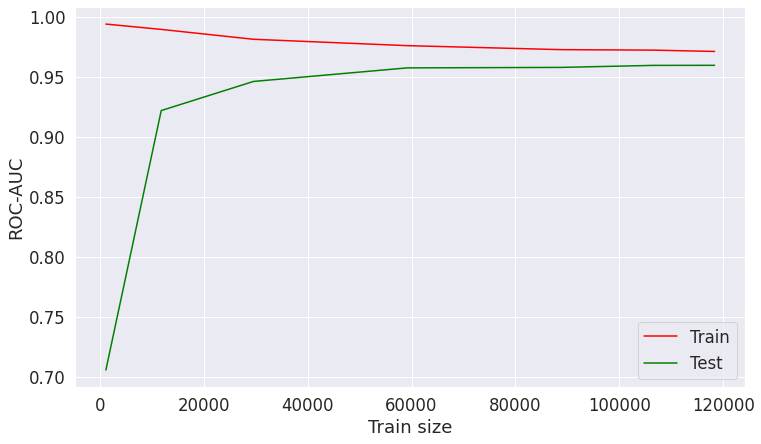

In [ ]:
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat3, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.3, random_state=17, shuffle=False)    
get_val_score(sgd_new1, X_train, y_train, X_val, y_val)
plot_learning_curve(sgd_new1, X_train, y_train)

In [ ]:
param_grid = {
              'alpha': np.logspace(-1, -7, 7),
              'l1_ratio': np.linspace(0, 1, 5),
              'max_iter': np.linspace(1000, 5000, 5),
              'class_weight': [None, 'balanced']
              }
cv_est = SGDClassifier(loss='log', random_state=17, n_jobs=-1, penalty='elasticnet')
gs_sgd_new = GridSearchCV(cv_est, param_grid=param_grid, scoring='roc_auc',
                        verbose=1, n_jobs=-1, return_train_score=True, cv=3)

In [ ]:
gs_sgd_new.fit(X_train, y_train)

In [ ]:
# Пробуем другое разбиение и добавим фич
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
feat_to_scale = time_diffs + ['session_timespan', 'unique_sites']
to_scale_df = new_feat_df1[feat_to_scale]
scaled_features = scale_features(to_scale_df, len(train_df))
new_feat4 = np.hstack([new_feat2.values, scaled_features])

In [ ]:
sgd = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
sgdb = SGDClassifier(loss='log', n_jobs=-1, random_state=17, class_weight='balanced')

Validation ROC-AUC score = 0.96507


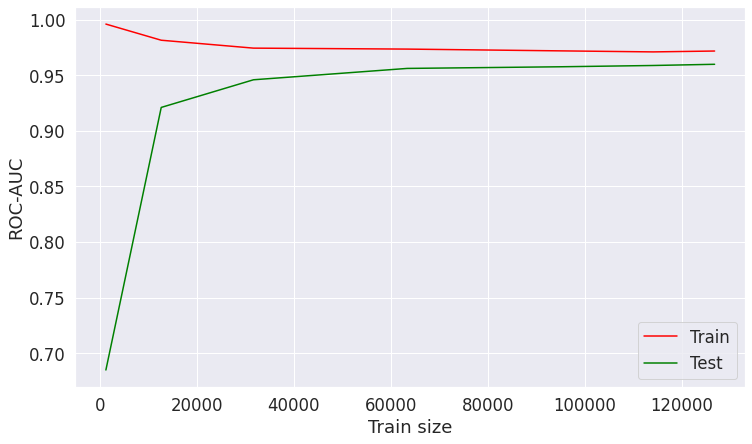

In [ ]:
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat4, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.25, random_state=17, stratify=y)    
get_val_score(sgd, X_train, y_train, X_val, y_val)
plot_learning_curve(sgd, X_train, y_train, cv=skf)

Validation ROC-AUC score = 0.97367


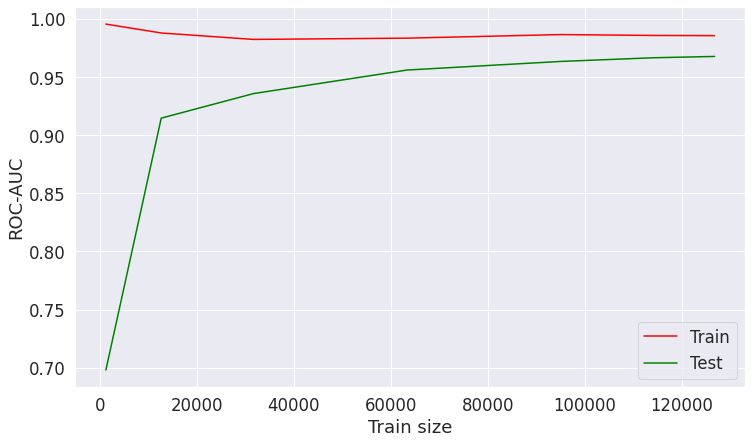

In [ ]:
X_train_new, X_test_new = add_features_to_sparse(train_test_sparse, new_feat4, len(train_df))
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y, test_size=0.25, random_state=17, stratify=y)    
get_val_score(sgdb, X_train, y_train, X_val, y_val)
plot_learning_curve(sgdb, X_train, y_train, cv=skf)

In [ ]:
sgd.fit(X_train_new, y)
test_pred = sgd.predict_proba(X_test_new)[:, 1]

In [ ]:
write_to_submission_file(test_pred, 'allfeat.csv')

In [ ]:
sgdb.fit(X_train_new, y)
test_pred = sgdb.predict_proba(X_test_new)[:, 1]

In [ ]:
write_to_submission_file(test_pred, 'allfeatbalance.csv')

Оценка на kaggle, к сожалению, лучше не стала.

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.